In [1]:
# Import packages.
import figure_utilities
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 150
plt.rcParams['savefig.dpi'] = 150
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd
from mixture_sampler import MixtureSampler

In [2]:
# Define paths.
INPUT_DATA = "../data/mcas.xls"
OUTPUT_FIGURES = "../figures/"
OUTPUT_TABLES = "../tables/"

In [3]:
# Load data.
df = pd.read_excel(INPUT_DATA)
y_variable = 'totsc4'
X_variables = ['tchratio', 'pctel', 'percap', 'lnch_pct']
k = len(X_variables)
X = df[X_variables].values
y = df[y_variable].values

In [4]:
# Log income before including in model.
df['percap'] = np.log(df['percap'])

# 1. Summary Statistics

In [5]:
# Table 1: Summary Statistics
summary_statistics_display_names = {'mean': "Mean",
                                    '50%': "Median",
                                    'std': "SD",
                                    'min': "Minimum", 
                                    'max': "Maximum"}
variable_display_names = {'totsc4': 'MCAS Score'}  # TODO
summary_statistics_table = (df
                            .describe()
                            .T[['mean', '50%', 'std', 'min', 'max']]
                            .drop(index='code')
                            .drop(index='totsc8')
                            .rename(columns=summary_statistics_display_names))
# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_table
         .rename(index=variable_display_names)
         .rename(columns=summary_statistics_display_names)
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'Maximum': "{:,.2f}",
                            'Minimum': "{:,.2f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="lccccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_table

,Mean,Median,SD,Minimum,Maximum
regday,4605.463636,4488.500000,880.252436,2905.000000,8759.000000
specneed,8900.726773,8353.790039,3511.696142,3832.229980,53569.238281
bilingua,3037.309091,0.000000,20259.258149,0.000000,295140.000000
occupday,1104.209091,0.000000,2732.448792,0.000000,15088.000000
tot_day,5370.250000,5155.000000,977.040427,3465.000000,9868.000000
s_p_c,8.107109,7.800000,2.835993,2.300000,18.400000
spec_ed,15.967727,15.450000,3.538000,8.100000,34.299999
lnch_pct,15.315909,10.550000,15.060068,0.400000,76.199997
tchratio,17.344091,17.100000,2.276666,11.400000,27.000000
percap,2.891501,2.840715,0.271459,2.270682,3.847058


# 2. Simulations

In [6]:
# Define an np.random.Generator to use for sampling.
generator = np.random.default_rng(seed=7)
N = 1000

In [7]:
# Set prior parameters.
prior_parameters = {}
prior_parameters['m'] = 3

# mu_j (location of mixture components) prior parameters.
prior_parameters['mu_j_underbar'] = 0
prior_parameters['h_underbar'] = 0.25  # This value will be re-drawn from the prior on h for every simulation.
prior_parameters['h_mu_underbar'] = 0.25

# beta prior parameters.
prior_parameters['beta_underbar'] = (np.linalg.inv(X.T @ X) @ (X.T @ y))
prior_parameters['H_underbar'] = X.T @ X

# h_j (scale of mixture components) prior parameters.
prior_parameters['nu_j_underbar'] = 1  # NOTE: Right now all h_j's are drawn from the same distribution.
prior_parameters['s2_j_underbar'] = 1

# h (scaling term for scale of mixture components) prior parameters.
prior_parameters['nu_underbar'] = 1
prior_parameters['s2_underbar'] = 1

# alphas prior parameters.
prior_parameters['alpha_underbar'] = np.ones(prior_parameters['m'])

# Define class which samples from priors
mixture_sampler = MixtureSampler(generator, prior_parameters, X, y)

## 2a. Prior Predictive Analysis

In this section, we perform prior predictive analysis using the following steps.

1. Draw all unobservables from their priors.
2. Sample a fictitious sample of y_i's from the likelihood function, conditional on these unobservables.
3. Calculate the mean, standard deviation, and largest deviation from the mean using this fictious sample.
4. Repeat 1000 times so that we have 1000 realizations each of mean, standard deviation, and largest deviation from the mean.
5. Calculate the mean, standard deviation, and largest deviation from the mean using the observed data.
6. For each statistic, plot a histogram of the 1000 realizations produced using the fictitious data.
7. For each statistic, overlay the realizationn calculated using the observed data.
8. Report the "p-value"

Note that while we explore more complex models with 5 and 7 mixture components later in our analysis, we only perform prior predictive analysis for our simplest model, with 3 mixture components.

In [8]:
fictitious_samples = []  # Will contain N vectors, each containinng 220 fictitious observations of y.
for draw in range(N):
    # Draw unobservables from their priors.
    current_draw_of_betas, current_draw_of_h, current_draw_of_alpha_js, current_draw_of_h_js, current_draw_of_mu_js = mixture_sampler.sample_from_prior()

    # Draw s_is.
    s_is = generator.choice(prior_parameters["m"], size=len(y), p=current_draw_of_alpha_js)

    # Draw y_is
    current_means_for_each_observation =  current_draw_of_mu_js[s_is] + (current_draw_of_betas @ X.T)
    current_h_js_for_each_observation = current_draw_of_h_js[s_is]
    current_y_is = generator.multivariate_normal(np.ravel(current_means_for_each_observation), np.diag(1 / current_h_js_for_each_observation))
    fictitious_samples.append(current_y_is)

# Convert list of fictitious samples into array.
fictitious_samples = np.vstack(fictitious_samples)

# Calculate statistics on fictitious samples.
fictitious_means = np.mean(fictitious_samples, axis = 1)
fictitious_stds = np.std(fictitious_samples, axis = 1)
fictitious_maxes_minus_means = np.max(fictitious_samples, axis = 1) - fictitious_means
fictitious_statistics = [fictitious_means, fictitious_stds, fictitious_maxes_minus_means]

# Calculate true values of each statistic.
true_mean = np.mean(y)
true_std = np.std(y)
true_max_minus_mean = np.max(y) - true_mean

In [9]:
# Plot.
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle("Prior Predictive Analysis Using Various Statistics")
titles = ["Mean", "S.D.", "Max. minus Mean"]
xlabels = ["$\\bar{y} = \\frac{1}{n}\sum_{i=1}^{n}y_i$",
          "$s_y = \sqrt{\\frac{1}{N-1} \sum_{i=1}^N (x_i - \overline{x})^2}$",
          "$\Delta_y = max\\{y_1, y_2, ..., y_n\\} - \\bar{y}$"]
vline_positions = [true_mean, true_std, true_max_minus_mean]
vline_labels = ["$\\bar{y}^0$", "$s_y^0$", "$\Delta_y^0$"]
for ax, fictitious_statistic, title, xlabel, vline_position, vline_label in zip(axes, fictitious_statistics, titles, xlabels, vline_positions, vline_labels):
    figure_utilities.plot_histogram(ax, fictitious_statistic, title=title, xlabel=xlabel)
    figure_utilities.plot_labeled_vline(ax, vline_position, vline_label)
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.savefig(os.path.join(OUTPUT_FIGURES, "prior_predictive_analysis.png"))
plt.close(fig)

## 2b. Evidence of Implementation Correctness

In this section, we perform Geweke's joint distribution test for correct implementation of our Gibbs sampler (Geweke 2004). We use the following steps:
1. Simulate unobservables from their priors. Note that in this step, it is not necessary for us to choose "sensible" priors, as this test is for implementation correctenss and is not intended to answer any research questions. We thus choose extremely simple priors in this section only.
2. Simulate a sample of y_is conditional on these observables
3. Simulate a sample of unobservables from their conditional distribution using our Gibbs sampler
4. Repeat steps 2 and 3 1000 times. Now, we have 1000 draws of our unobservables.
5. Compare the distribution of these unobservables to our prior distributions.

In [10]:
# Temporarily set the prior parameters on our betas to something simple.
simple_prior_parameters = prior_parameters.copy()
simple_prior_parameters['beta_underbar'] = np.zeros(k)
simple_prior_parameters['H_underbar'] = np.eye(k)
simple_mixture_sampler = MixtureSampler(generator, simple_prior_parameters, X, y)
current_draw_of_betas, current_draw_of_h, current_draw_of_alpha_js, current_draw_of_h_js, current_draw_of_mu_js = simple_mixture_sampler.sample_from_prior()
current_draws_of_s_is = generator.choice(prior_parameters["m"], size=len(y), p=current_draw_of_alpha_js)
all_betas_prior = np.vstack(list(simple_mixture_sampler.sample_from_prior()[0] for i in range(N)))
all_betas_posterior = []
for i in range(N):
    # Draw y_is
    current_means_for_each_observation =  current_draw_of_mu_js[current_draws_of_s_is] + (current_draw_of_betas @ X.T)
    current_h_js_for_each_observation = current_draw_of_h_js[current_draws_of_s_is]
    current_y_is = generator.multivariate_normal(np.ravel(current_means_for_each_observation), np.diag(1 / current_h_js_for_each_observation))

    # Assign simulated y_is to the sampler.
    mixture_sampler.y = current_y_is

    # Draw new unobservables conditional on y_is
    current_draw_of_betas, current_draw_of_h, current_draw_of_alpha_js, current_draw_of_h_js, current_draw_of_mu_js, current_draws_of_s_is = simple_mixture_sampler.sample_from_posterior()

    all_betas_posterior.append(current_draw_of_betas)
all_betas_posterior = np.vstack(all_betas_posterior)


# Restore beta prior parameters to original values.
prior_parameters['beta_underbar'] = (np.linalg.inv(X.T @ X) @ (X.T @ y))
prior_parameters['H_underbar'] = X.T @ X



In [11]:
# Test for equality of prior beta samples and simulated posterior beta samples.

geweke_test_results = pd.DataFrame(np.column_stack([np.mean(all_betas_prior, axis=0),
                                    np.mean(all_betas_posterior, axis=0),
                                    stats.ttest_ind(all_betas_prior, all_betas_posterior, axis=0).pvalue]),
                                   columns=["Mean of Samples from $N(\\underline{0}, I_k)$",
                                            "Mean of Posterior Samples of $\\beta$",
                                            "P-Value From Difference in Means Test"],
                                   index=["$\\beta_{tchratio}$", "$\\beta_{pctel}$", "$\\beta_{percap}$", "$\\beta_{lnch_pct}$"])
# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "geweke_joint_distribution_test.tex")
latex = (geweke_test_results
         .style
         .format(formatter="{:,.2f}")
         .to_latex(None,
                   column_format="lccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
geweke_test_results

,"Mean of Samples from $N(\underline{0}, I_k)$",Mean of Posterior Samples of $\beta$,P-Value From Difference in Means Test
$\beta_{tchratio}$,-0.014226,-0.008140,0.891268
$\beta_{pctel}$,-0.008394,0.013946,0.603328
$\beta_{percap}$,-0.039580,0.037798,0.080048
$\beta_{lnch_pct}$,-0.005158,-0.009206,0.927796


## 2c. Evidence of Posterior Simulation Convergence

In this section, we confirm that our posterior simulator has converged. We show that our posterior simulator has converged using two main methods. Here are the steps we take to show convergence using method 1:
1. Draw a sample from the joint posterior of the unobservables using our Gibbs sampler.
2. Draw a fictitious sample of y_is from the likelihood
3. Repeat many times
4. Now, we have many samples of y_is. Compute the mean and standard deviation of each sample and plot.

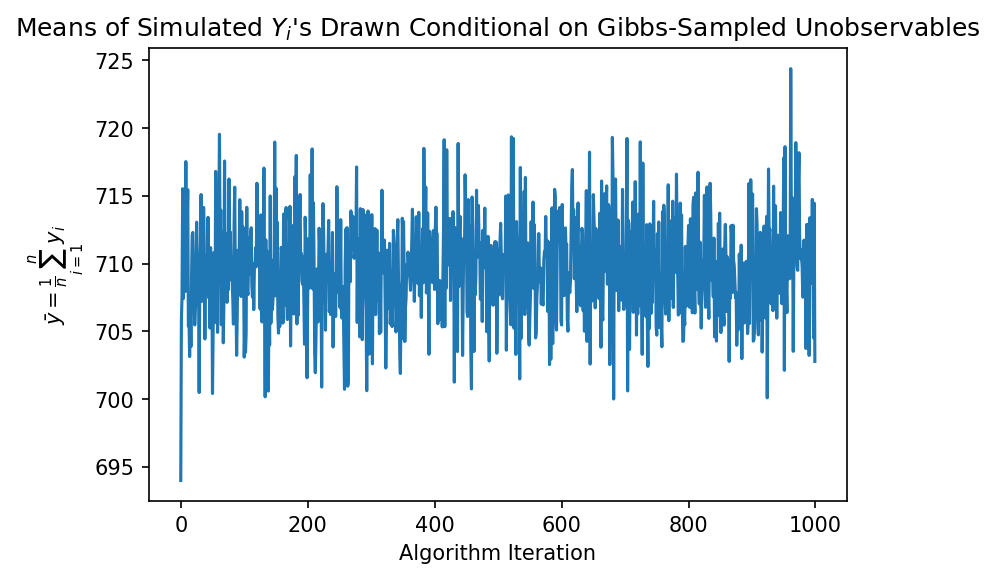

<Figure size 900x600 with 0 Axes>

In [23]:
draws_of_betas, draws_of_h, draws_of_alpha_js, draws_of_h_js, draws_of_mu_js, draws_of_s_is = mixture_sampler.sample_from_posterior(N)


all_simulated_y_is = []
for draw_of_beta, draw_of_h, draw_of_alpha_js, draw_of_h_js, draw_of_mu_js, draw_of_s_is in zip(draws_of_betas, draws_of_h, draws_of_alpha_js, draws_of_h_js, draws_of_mu_js, draws_of_s_is):

    # Draw y_is
    current_means_for_each_observation =  draw_of_mu_js[draw_of_s_is] + (draw_of_beta @ X.T)
    current_h_js_for_each_observation = draw_of_h_js[draw_of_s_is]
    current_y_is = generator.multivariate_normal(np.ravel(current_means_for_each_observation), np.diag(1 / current_h_js_for_each_observation))

    all_simulated_y_is.append(current_y_is)
all_simulated_y_is = np.vstack(all_simulated_y_is)
means = np.mean(all_simulated_y_is, axis=1)

fig, ax = plt.subplots(1, 1)
ax.plot(means)
ax.set_title("Means of Simulated $Y_i$'s Drawn Conditional on Gibbs-Sampled Unobservables")
ax.set_ylabel("$\\bar{y} = \\frac{1}{n}\sum_{i=1}^{n}y_i$")
ax.set_xlabel("Algorithm Iteration")
plt.show()
plt.savefig(os.path.join(OUTPUT_FIGURES, "convergence_check_1.png"))
plt.close(fig)


In our second method, we compare the distribution of the second quarter of draws to the distribution of the fourth quarter of draws. We do this for every unobservable. Multidimensional unobservables (betas, h_j's, mu_j's) are averaged to avoid "labeling" issues; we weight these averages using the alpha_j's, following Professor Norets' recommendation. For each unobservable, we take the following steps:
1. Plot the second 25 percent of values and the last 25 percent of values.
2. Perform a difference in means test between the second 25 percent of draws and the last 25 percent of draws.

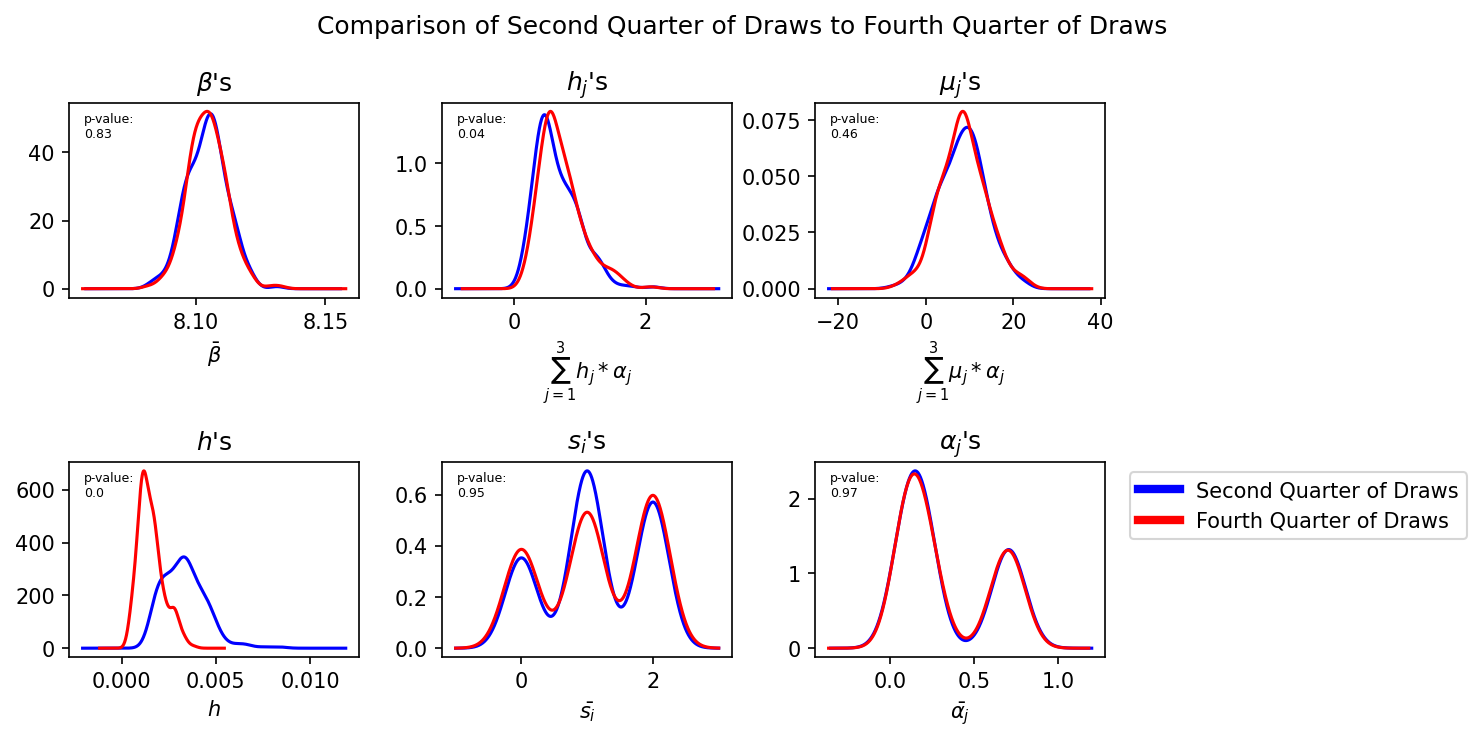

In [13]:
# Draw from posterior. NOTE: May be able to drop this check; Prof. Norets said first one is better anyway
draws_of_betas, draws_of_h, draws_of_alpha_js, draws_of_h_js, draws_of_mu_js, draws_of_s_is = mixture_sampler.sample_from_posterior(num_samples=1000)
draws_of_betas = np.mean(draws_of_betas, axis=1)
draws_of_h_js = np.average(draws_of_h_js, axis=1, weights=draws_of_alpha_js)
draws_of_mu_js = np.average(draws_of_mu_js, axis=1, weights=draws_of_alpha_js)

unobservables_to_check = [draws_of_betas, draws_of_h_js, draws_of_mu_js, draws_of_h, draws_of_s_is, draws_of_alpha_js]
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
fig.suptitle("Comparison of Second Quarter of Draws to Fourth Quarter of Draws")
axes = [ax for l in axes for ax in l]
titles = ["$\\beta$\'s", "$h_j$\'s", "$\\mu_j$\'s", "$h$\'s", "$s_i$\'s", "$\\alpha_j$\'s"]
xlabels = ["$\\bar{\\beta}$", "$\\sum_{j=1}^{3} h_j*\\alpha_j$", "$\\sum_{j=1}^{3} \\mu_j*\\alpha_j$", "$h$", "$\\bar{s_i}$", "$\\bar{\\alpha_j}$"]
for ax, unobservable, xlabel, title in zip(axes, unobservables_to_check, xlabels, titles):
    current_unobservable = pd.Series(np.reshape(unobservable, -1))
    current_unobservable.loc[0.25*N:0.5*N+1].plot(ax=ax, kind='kde', color='blue')
    current_unobservable.loc[0.75*N:N].plot(ax=ax, kind='kde', color='red')

    p_value = stats.ttest_ind(current_unobservable.loc[0.25*N:0.5*N+1],current_unobservable.loc[0.75*N:N] ).pvalue
    ax.text(0.05, 0.95, f"p-value:\n{round(p_value, 2)}", horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=6)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("")
    ax.set_title(title)
plt.legend([Line2D([0], [0], color='blue', lw=4), Line2D([0], [0], color='red', lw=4)], ['Second Quarter of Draws', 'Fourth Quarter of Draws'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FIGURES, "convergence_check_2.png"))
plt.show()
plt.close(fig)


## 2d. Comparison of Models

In this section, we compare model fit across different levels of model complexity. The model previously explored in this analysis used three mixture components. We next estimate two other models, with 5 and 7 mixture components respectively, and compare their model fit to our original model

In [ ]:
logscores = {3: [], 5: [], 7: []}
for m in [3, 5, 7]:
    current_prior_parameters = prior_parameters.copy()
    current_prior_parameters["m"] = m
    current_prior_parameters['alpha_underbar'] = np.ones(current_prior_parameters['m'])
    for split in range(50):
        # Split into estimation and evaluation samples.
        train_df, test_df = train_test_split(df, test_size=0.15)
        current_train_X = train_df[X_variables].values
        current_train_y = train_df[y_variable].values
        current_test_X = test_df[X_variables].values
        current_test_y = test_df[y_variable].values

        current_sampler = MixtureSampler(generator, current_prior_parameters, current_train_X, current_train_y)

        # Draw unobservables.
        [draws_of_betas, draws_of_h, draws_of_alpha_js, draws_of_h_js, draws_of_mu_js, draws_of_s_is] = current_sampler.sample_from_posterior(num_samples=1000)

        # Save draw 1000.
        current_beta = draws_of_betas[-1]
        current_h = draws_of_h[-1]
        current_alpha_js = draws_of_alpha_js[-1]
        current_h_js = draws_of_h_js[-1]
        current_mu_js = draws_of_mu_js[-1]
        current_s_i_equals_js = np.random.choice(m, p=current_alpha_js, size=len(current_test_y))

        current_logscore = 0
        for i in range(len(current_test_y)):
            current_component = current_s_i_equals_js[i]
            current_mean = current_mu_js[current_component] + (current_beta @ current_test_X[i].T)
            current_precision = current_h_js[current_component]
            current_logscore += stats.norm(current_mean, 1 / current_precision).pdf(current_test_y[i])
        logscores[m].append(current_logscore)

In [14]:
mean_logscores = []
for component in logscores.keys():
    mean_logscore = sum(logscores[component]) / len(logscores[component])
    mean_logscores.append(mean_logscore)
model_comparison_table = pd.Series(mean_logscores, index=["3", "5", "7"])
model_comparison_table.index.name = "Model Components"
model_comparison_table.name = "Mean Logscore"

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "log_scores.tex")
latex = (model_comparison_table
         .style
         .format(formatter="{:,.2f}")
         .to_latex(None,
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
model_comparison_table